# Lab 4: Humidity

In this lab, a variable capacitor was used to measure the humidity in the room.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy
%matplotlib inline

## Hardware Setup

![Circuit Diagram](img/circuit.png)

This circuit was set up as a simple RC circuit. The humidity sensor is a variable capacitor, so an AC wave can be sent through the RC circuit to determine the capacitance of the humidity sensor, which can be converted to relative humidity.

## Data

Five capacitors were inserted into this circuit in place of the humidity sensor to get a baseline calibration curve of the RMS response across the capacitor to a 1kHz AC square wave input. The response RMS was recorded in the calibration table, to be used to calculate the capacitance of the humidity sensor.

In addition, two RMS measurements were taken from the humidity sensor, one with the humidity sensor as is, and one after breathing onto the humidity sensor, which should increase RH.

In [10]:
# Raw Data
# Calibration data in (capacitance (pF), RMS (V))
calibration_data = [
    (100, 0.3380),
    (120, 0.3242),
    (150, 0.2916),
    (180, 0.2681),
    (220, 0.2389),
]

calibration_data_df = pd.DataFrame(calibration_data)
calibration_data_df.columns = ['Capacitance', 'RMS']
calibration_data_df.set_index('RMS', inplace=True)

humidity_norm_rms = 0.2685
humidity_breath_rms = 0.2616

humidity_rh = 53  # RH, in %. Found by asking siri
resistor = 10 * 10 ** 3  # 10 kOhm resistor

raw_data_csv = 'data/humidity_measurements.csv'
raw_data_df = pd.read_csv(raw_data_csv)


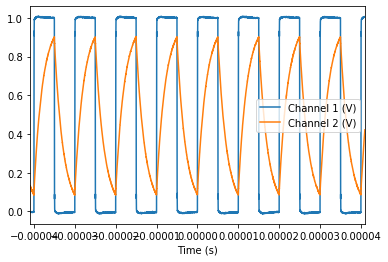

In [3]:
# Plot raw data
raw_data_df.plot(x='Time (s)', y=['Channel 1 (V)', 'Channel 2 (V)'])

Text(0, 0.5, 'Capacitance (pF)')

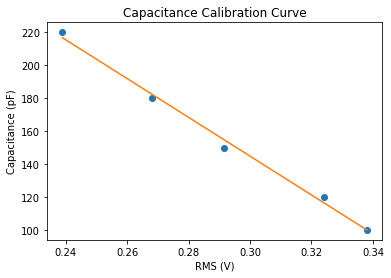

In [4]:
# Generate Linear Regression and plot
cap_cal = np.poly1d(np.polyfit(x=calibration_data_df.index, y=calibration_data_df['Capacitance'], deg=1))
calibration_data_df['trendline'] = cap_cal(calibration_data_df.index)
ax = plt.plot(calibration_data_df.index, calibration_data_df['Capacitance'], 'o')
ax = plt.plot(calibration_data_df.index, calibration_data_df['trendline'], '-')
plt.title('Capacitance Calibration Curve')
plt.xlabel('RMS (V)')
plt.ylabel('Capacitance (pF)')

### Humidity sensor data analysis

The calibration curve can be used to calculate the capacitance of the humidity sensor. The capacitance can then be used along with the table in the humidity sensor datasheet to interpolate the RH of the room.

In [5]:
# Find capacitance of humidity data
humidity_norm_cap = cap_cal(humidity_norm_rms)
humidity_breath_cap = cap_cal(humidity_breath_rms)
print("Humidity Normal Capacitance: {} pF".format(humidity_norm_cap))
print("Humidity with breathing Capacitance: {} pF".format(humidity_breath_cap))

Humidity Normal Capacitance: 181.85242826221042 pF
Humidity with breathing Capacitance: 189.97507217638002 pF


In [6]:
# Calibration to get humidity

# Calibration data in (RH (%), capacitance (pF))
# From https://media.digikey.com/pdf/Data%20Sheets/Measurement%20Specialties%20PDFs/HS1101LF.pdf
hum_cal_data = [
    (0, 161.6),
    (5, 163.6),
    (10, 165.4),
    (15, 167.2),
    (20, 169.0),
    (25, 170.7),
    (30, 172.3),
    (35, 173.9),
    (40, 175.5),
    (45, 177.0),
    (50, 178.5),
    (55, 180.0),
    (60, 181.4),
    (65, 182.9),
    (70, 184.3),
    (75, 185.7),
    (80, 187.2),
    (85, 188.6),
    (90, 190.1),
    (95, 191.6),
    (100, 193.1),
]

hum_cal_df = pd.DataFrame(hum_cal_data)

hum_cal_df.columns = ['RH', 'Capacitance']
hum_cal_df.set_index('Capacitance', inplace=True)

Text(0, 0.5, 'RH (%)')

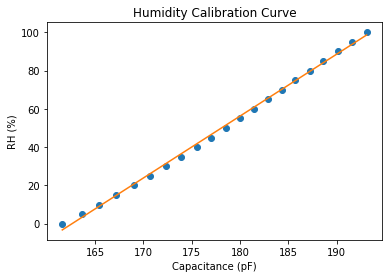

In [7]:
hum_cal = np.poly1d(np.polyfit(x=hum_cal_df.index, y=hum_cal_df['RH'], deg=1))
hum_cal_df['trendline'] = hum_cal(hum_cal_df.index)
ax = plt.plot(hum_cal_df.index, hum_cal_df['RH'], 'o')
ax = plt.plot(hum_cal_df.index, hum_cal_df['trendline'], '-')

plt.title('Humidity Calibration Curve')
plt.xlabel('Capacitance (pF)')
plt.ylabel('RH (%)')

In [8]:
# Calculate humidities
humidity_norm = hum_cal(humidity_norm_cap)
humidity_breath = hum_cal(humidity_breath_cap)
print("Humidity Normal: {}%".format(humidity_norm))
print("Humidity with breathing: {}%".format(humidity_breath))

Humidity Normal: 62.2105920608185%
Humidity with breathing: 88.47543471940276%


## Analytical Solution

The theoretical RMS can be found by calculating the capacitance from the datasheet, then calculating the theoretical RMS by analyzing the RC circuit.

### RC Circuit analysis

Given the RC circuit equation:

$$ V_{out} = V_\infty (1 - e^{{-t\over{\tau}}}) $$

We can generate what the theoretical capacitor behavior should be. The capacitor should charge up to the $V_{out}$ when $t$ is the length of a single step, and the theoretical RMS is half of that voltage.

In [71]:
# Calculate theoretical capacitance
hum_cal_inv = np.poly1d(np.polyfit(x=hum_cal_df['RH'], y=hum_cal_df.index, deg=1))
hum_cap_theory = hum_cal_inv(humidity_rh) * 10 ** -12
print('Theoretical Capacitance: {} pF'.format(hum_cap_theory * 10 ** 12))

Theoretical Capacitance: 179.00221645021637 pF


In [69]:
# Calculate RMS from capacitance
stair_freq = 100 * 10 ** 4  # 100 kHz
stair_period = 1 / stair_freq  # second
stair_amp = 1  # V
tau = hum_cap_theory * resistor  # time constant, seconds

vout_up = stair_amp * (1 - np.exp(-stair_period / tau))
rms = vout_up / 2
print('Theoretical RMS: {} V'.format(rms))

Theoretical RMS: 0.21401029948008626 V


## Conclusions

The measured humidity from the humidity sensor was 62.2%. This was significantly higher than the official humidity in Needham of the day, which was 53%. This can be caused by localized differences in weather specific to the room we were in, but more plausibly, was from inaccuracies in measuring the capacitor. This is supported from the fact that during pset 4, the theoretical charging of the capacitor was much faster than the actual measured voltage change, which also happened in this lab. In fact, the actual theoretical capacitance was similar to the measured capacitance of the sensor, however, the small change in capacitance is a major change in relative humidity.